In [50]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

In [51]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}
vocab_size = len(stoi)

In [52]:
# creating the dataset
context_len = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * context_len
        for ch in w+'.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

# creating the test/train/validation sets
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1]) # 80% of the data
X_test, Y_test = build_dataset(words[n1:n2]) # 10% of the data
X_dev, Y_dev = build_dataset(words[n2:]) # 10% of the data

def calculate_loss():
    return None

print('X_train.shape -->', X_train.shape, 'Y_train.shape -->', Y_train.shape)
print('X_test.shape -->', X_test.shape, 'Y_test.shape -->', Y_test.shape)
print('X_dev.shape -->', X_dev.shape, 'Y_dev.shape -->', Y_dev.shape)


X_train.shape --> torch.Size([182625, 3]) Y_train.shape --> torch.Size([182625])
X_test.shape --> torch.Size([22655, 3]) Y_test.shape --> torch.Size([22655])
X_dev.shape --> torch.Size([22866, 3]) Y_dev.shape --> torch.Size([22866])


In [53]:
# Make the code more pytorch like

g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, n_in, n_out, bias=True):
        self.weights = torch.randn(n_in, n_out, generator=g) / (n_in ** 0.5)
        self.bias = torch.zeros(n_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        if self.bias is not None:
            return [self.weights, self.bias]
        else:
            return [self.weights]


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, moementum=0.1):
        self.eps = eps
        self.moementum = moementum
        self.training = True
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        return None
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=0)
            self.running_var = (1-self.moementum) * self.running_var + self.moementum * xvar
            self.running_mean = (1-self.moementum) * self.running_mean + self.moementum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / ((xvar + self.eps) ** 0.5)
        self.out = (self.gamma * xhat) + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [62]:
# network parameters
n_embd = 10
n_hidden = 100
batch_size = 32
C = torch.randn(vocab_size, n_embd, generator=g) 

layers = [
    Linear(n_embd * context_len, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# make the softmax layer less confident in its initial predictions
with torch.no_grad():
    layers[-1].weights *= 0.1
# boost the linear layers before the tanh by 5/3 in order to fight the squashing
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weights *= 5/3

parameters = [p for layer in layers for p in layer.parameters()] + [C]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


46497


In [63]:
#model
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #sampling the batch
    idx = torch.randint(0 ,X_train.shape[0], (batch_size,), generator=g) # (batch_size,)
    Xb, Yb = X_train[idx], Y_train[idx] # (batch_size, context_len), (batch_size,)
 
    #forward pass
    emb = C[Xb]  # (batch_size, context_len, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (batch_size, n_embd * context_len)
    logits = embcat
    for layer in layers:
        logits = layer(logits)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # append loss to lossi
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.2992


In [64]:
# with torch.no_grad():
#     #calcultae the bnmean and bnbias as stage 2
#     emb = C[X_train]  # (batch_size, context_len, n_embd)
#     embcat = emb.view(emb.shape[0], -1) # (batch_size, n_embd * context_len)
#     hpreact = embcat @ W1 # + b1 # (batch_size, n_hidden)
#     bnmean = hpreact.mean(dim=0, keepdim=True)
#     bnstd = hpreact.std(dim=0, keepdim=True)

In [65]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'test' : (X_test, Y_test),
        'train' : (X_train, Y_train),
        'dev' : (X_dev, Y_dev)
    }[split]
    emb = C[x]  # (batch_size, context_len, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (batch_size, n_embd * context_len)
    logits = embcat
    for layer in layers:
        logits = layer(logits)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss:.4f}')

split_loss('train')
split_loss('test')
split_loss('dev')

train loss: 3.2754
test loss: 3.2763
dev loss: 3.2753


In [66]:
# before any optimizations
    # train loss: 2.1190
    # test loss: 2.1607
    # dev loss: 2.1675

# Fixing the initialization of the w2 and setting b2 to zero 
    # train loss: 2.0693
    # test loss: 2.1332
    # dev loss: 2.1368

# Fixing the oversaturation of the tanh layer by scaling down the w1 and b1
    # train loss: 2.0343
    # test loss: 2.1023
    # dev loss: 2.1058

# Loss after adding batch normalization
    # train loss: 2.0668
    # test loss: 2.1048
    # dev loss: 2.1065


In [67]:
# plt.figure(figsize=(10, 20))
# plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [68]:
# h_act = h.view(-1).tolist()
# plt.hist(h_act, bins=50);
# hpreact_act = hpreact.view(-1).tolist()
# # plt.hist(hpreact_act, bins=50);

layer 1 (      Tanh): mean +0.01, std 0.77, saturated: 22.52%
layer 3 (      Tanh): mean +0.03, std 0.68, saturated: 8.97%
layer 5 (      Tanh): mean +0.01, std 0.67, saturated: 7.55%
layer 7 (      Tanh): mean +0.03, std 0.66, saturated: 6.12%
layer 9 (      Tanh): mean +0.01, std 0.65, saturated: 5.95%


Text(0.5, 1.0, 'activation distribution')

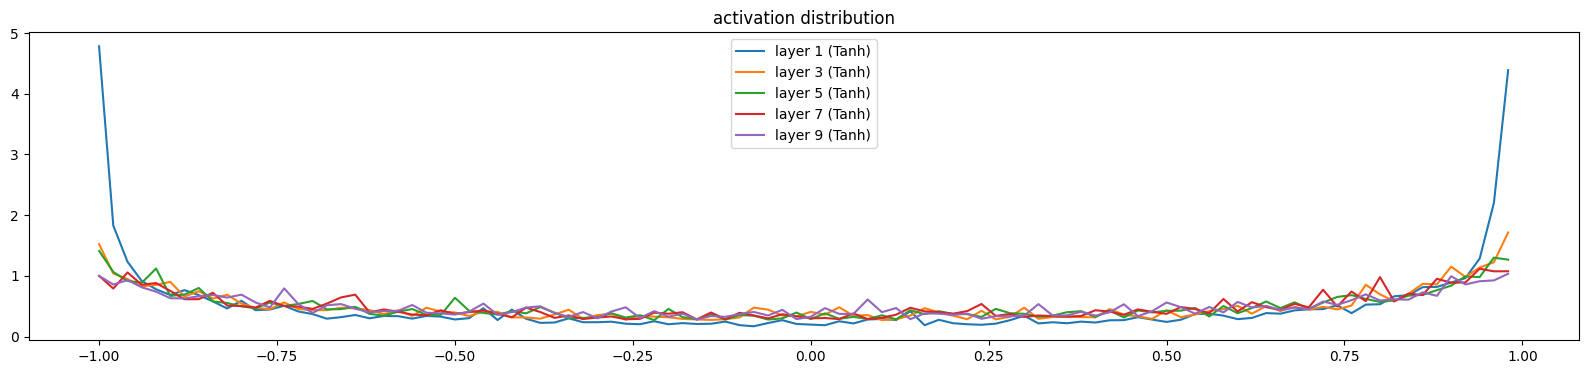

In [69]:
#visualizing forward pass activations of tanh layers
plt.figure(figsize=(20,4))
legends=[]
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')


In [ ]:
#visualizing forward pass activations of tanh layers
plt.figure(figsize=(20,4))
legends=[]
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')


In [117]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(10):
    str = ''
    idx = [0] * context_len
    while True:
        emb = C[torch.tensor([idx])]
        embcat = emb.view(1, -1) # (batch_size, n_embd * context_len)
        hpreact = embcat @ W1# + b1 # (batch_size, n_hidden)
        # adding batch normalization
        hpreact = (hpreact - bnrunning_mean) / bnrunning_std
        hpreact = (bngain  * hpreact) + bnbias
        h = torch.tanh(hpreact) # (batch_size, n_hidden)
        logits = h @ W2 + b2 # (batch_size, vocab_size)
        probs = F.softmax(logits, dim=1)
        new_idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        if new_idx == 0:
            break;
        str += itos[new_idx]
        idx = idx[1:] + [new_idx]
    print(str)
    

carmahea
brielle
jerli
thty
skanden
jenontla
merrit
kaqhiuoranni
jameihvin
legy
